In [38]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string


In [39]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('Online_Retail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [40]:
# shape of df

retail.shape

(541909, 8)

In [41]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [42]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [43]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [44]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [45]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### Menganalisis Customers berdasarkan 3 faktor di bawah ini:
- R (Recency): Number of days since last purchase/ interaksi pelanggan terakhir
- F (Frequency): Number of tracsactions / jumlah transaksi
- M (Monetary): Total amount of transactions (revenue contributed) / total transaksi

In [46]:
# New Attribute : Monetary (Menghitung Total Nilai Pembelian per Pelanggan)

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [47]:
# New Attribute : Frequency (Menghitung Frekuensi Pembelian per Pelanggan)

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [48]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [49]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%m/%d/%y %H:%M', errors='coerce')
# df['tanggal_waktu'] = pd.to_datetime(df['tanggal_waktu'], format='%m/%d/%y %H:%M', errors='coerce')


In [50]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [51]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [52]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [53]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [54]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical

Statistical Outliers: Outliers ini diidentifikasi berdasarkan analisis statistik dari distribusi data.
- Domain specific

Domain-Specific Outliers: Outliers ini diidentifikasi berdasarkan pengetahuan khusus domain atau pemahaman tentang karakteristik data.

Text(0.5, 0, 'Attributes')

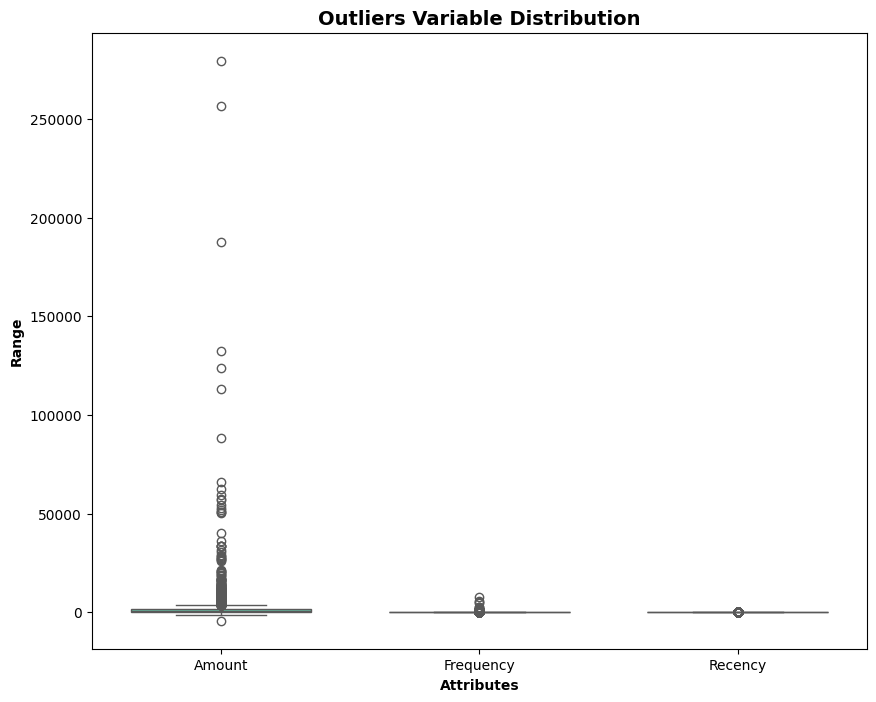

In [55]:
# Outlier Analysis of Amount Frequency and Recency
import matplotlib.pyplot as plt
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [56]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]
rfm1=rfm
rfm1



,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
...,...,...,...,...
4366,18278.0,173.90,9,73
4367,18280.0,180.60,10,277
4368,18281.0,80.82,7,180
4369,18282.0,176.60,13,7


### Rescaling the Attributes

Rescaling atau normalisasi atribut dalam analisis data adalah proses mengubah nilai-nilai dari berbagai atribut ke dalam skala yang serupa atau relatif sama. 
Terdapat dua metode rescaling yang umum digunakan:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

di bawah ini menggunakan Standardisation Scaling.

In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Asumsikan Anda memiliki DataFrame rfm1 dengan kolom-kolom yang telah Anda sebutkan
# CustomerID	Amount	Frequency	Recency

# Pisahkan kolom 'CustomerID'
customer_ids = rfm1['CustomerID']
rfm_data = rfm1[['Amount', 'Frequency', 'Recency']]

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit_transform hanya pada data RFM
rfm_scaled = scaler.fit_transform(rfm_data)

# Buat DataFrame hasil scaling
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Amount', 'Frequency', 'Recency'])

# Gabungkan kembali dengan kolom 'CustomerID'
rfm_scaled_with_id = pd.concat([customer_ids.reset_index(drop=True), rfm_scaled_df], axis=1)

# Tampilkan hasilnya
rfm_scaled_with_id


,CustomerID,Amount,Frequency,Recency
0,12346.0,-0.723738,-0.752888,2.301611
1,12347.0,1.731617,1.042467,-0.906466
2,12348.0,0.300128,-0.463636,-0.183658
3,12349.0,0.277517,-0.044720,-0.738141
4,12350.0,-0.533235,-0.603275,2.143188
...,...,...,...,...
4288,18278.0,-0.624669,-0.683068,-0.193560
4289,18280.0,-0.620853,-0.673094,1.826341
4290,18281.0,-0.677696,-0.703017,0.865898
4291,18282.0,-0.623131,-0.643171,-0.847057


In [58]:
# Rescaling the attributes

rfm_df = rfm1[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape


(4293, 3)

In [59]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()


,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

K-Means clustering adalah salah satu algoritma machine learning yang sederhana dan populer untuk tugas unsupervised learning. Algoritma ini bekerja sebagai berikut:

1. **Inisialisasi Titik-Titik Pusat (Means):**
   - Tahap awal, kita secara acak memilih \(k\) titik, yang disebut sebagai pusat (means).
   - Jumlah \(k\) ini menandakan jumlah klaster yang ingin kita bentuk.

2. **Kategorisasi Setiap Item ke Pusat Terdekat:**
   - Setiap data atau item dikategorikan ke dalam klaster yang memiliki pusat terdekat. Jarak antara data dan pusat diukur, dan data ditempatkan di dalam klaster dengan pusat terdekat.

3. **Pembaruan Koordinat Pusat (Means):**
   - Setelah seluruh data dikategorikan ke dalam klaster, kita perbarui koordinat pusat klaster tersebut.
   - Pusat baru dihitung sebagai rata-rata koordinat dari seluruh data yang berada di dalam klaster tersebut.

4. **Iterasi Proses:**
   - Langkah-langkah 2 dan 3 diulangi untuk sejumlah iterasi tertentu atau sampai konvergensi tercapai.
   - Iterasi ini membantu menyempurnakan posisi pusat klaster dan penempatan data di dalam klaster yang sesuai.

5. **Selesai, Hasil Klaster Terbentuk:**
   - Setelah iterasi selesai, kita mendapatkan hasil klaster yang terbentuk. Data telah dikelompokkan berdasarkan kesamaan dan perbedaan karakteristiknya.

In [60]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=4)

In [61]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0])

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


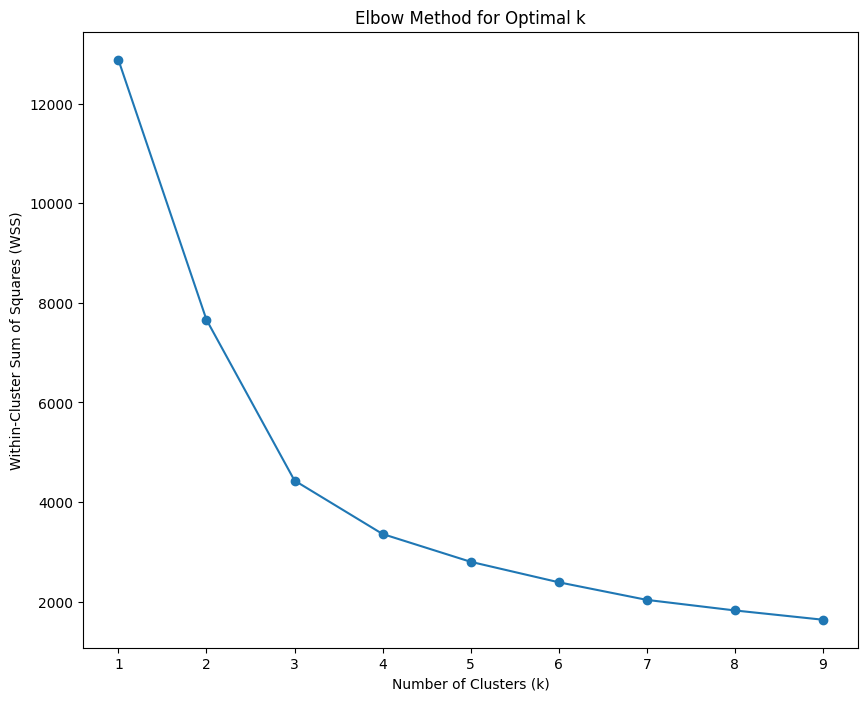

In [62]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Inisialisasi nilai k
k_values = range(1, 10)
# range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Inisialisasi list untuk menampung nilai WSS
wss_values = []

# Melakukan KMeans untuk setiap nilai k dan menghitung WSS
for k in k_values:
    kmeans = KMeans(n_clusters=k,max_iter=50,random_state=42)
    kmeans.fit(rfm_df_scaled)
    wss_values.append(kmeans.inertia_)

# Menampilkan grafik elbow
plt.plot(k_values, wss_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.show()


### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

Silhouette score adalah ukuran sejauh mana suatu objek mirip dengan kelompoknya sendiri (koherensi) dibandingkan dengan kelompok lainnya (pemisahan). Skor silhouette berkisar antara -1 hingga 1, dan interpretasinya sebagai berikut:

1. **Lebih dekat ke 1:** Skor silhouette yang lebih dekat ke 1 menunjukkan bahwa objek data tersebut sangat mirip dengan kelompoknya sendiri dan kurang mirip dengan kelompok tetangga. Ini berarti bahwa objek tersebut relatif mirip dengan objek data lain dalam kelompoknya dan berbeda dengan objek data dalam kelompok lain.

2. **Lebih dekat ke 0:** Skor silhouette mendekati 0 menunjukkan adanya tumpang tindih antara kelompok, di mana objek data mungkin berada di atau sangat dekat dengan batas keputusan antara dua kelompok tetangga.

3. **Lebih dekat ke -1:** Skor silhouette yang lebih dekat ke -1 menunjukkan bahwa objek data mungkin salah klasifikasi atau ditempatkan di kelompok yang salah. Dengan kata lain, objek tersebut tidak terlalu mirip dengan objek data dalam kelompok yang ditugaskan dan lebih mirip dengan objek data dalam kelompok lain.

Secara ringkas, skor silhouette yang lebih tinggi biasanya diinginkan karena menunjukkan bahwa objek data terkelompok dengan baik dan memiliki pemisahan yang jelas antara kelompok. Skor ini memberikan ukuran seberapa sesuai jumlah kelompok yang dipilih untuk data yang diberikan.

implementasi analisis silhouette untuk mengevaluasi performa algoritma K-Means pada berbagai jumlah kluster (n_clusters) yang berbeda:

1. **Looping through `range_n_clusters`:** Melalui loop tersebut, kita mencoba beberapa jumlah kluster yang berbeda, yaitu 2, 3, 4, 5, 6, 7, dan 8.

2. **Inisialisasi K-Means:** Untuk setiap jumlah kluster, kita menginisialisasi model K-Means dengan jumlah kluster tersebut menggunakan `KMeans(n_clusters=num_clusters, max_iter=50)`.

3. **Melatih Model K-Means:** Model K-Means kemudian dilatih dengan data yang telah diubah skala (`rfm_df_scaled`).

4. **Menghitung Label Kluster:** Setelah pelatihan, kita mengambil label kluster untuk setiap sampel dalam data.

5. **Menghitung Skor Silhouette:** Dengan menggunakan label kluster, kita menghitung skor silhouette menggunakan fungsi `silhouette_score(rfm_df_scaled, cluster_labels)`. Skor ini memberikan ukuran seberapa baik objek-objek dalam kelompok bersama dan seberapa terpisah kelompok-kelompok tersebut.

6. **Menampilkan Hasil:** Hasil skor silhouette untuk setiap jumlah kluster dicetak ke layar.

Analisis ini membantu dalam menentukan jumlah kluster yang optimal untuk membagi data sehingga membentuk kelompok-kelompok yang kohesif dan terpisah. Jumlah kluster yang memberikan skor silhouette tertinggi dianggap sebagai pilihan yang lebih baik untuk model K-Means.

c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=2, the silhouette score is 0.5411246404292333


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=3, the silhouette score is 0.5084896296141937


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=4, the silhouette score is 0.4777820100216849


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=5, the silhouette score is 0.4638787576606892


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=6, the silhouette score is 0.4175157039718109


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=7, the silhouette score is 0.41593154317581155


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=8, the silhouette score is 0.4120880818988536


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=9, the silhouette score is 0.41446287444794255


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=10, the silhouette score is 0.3795497365288136


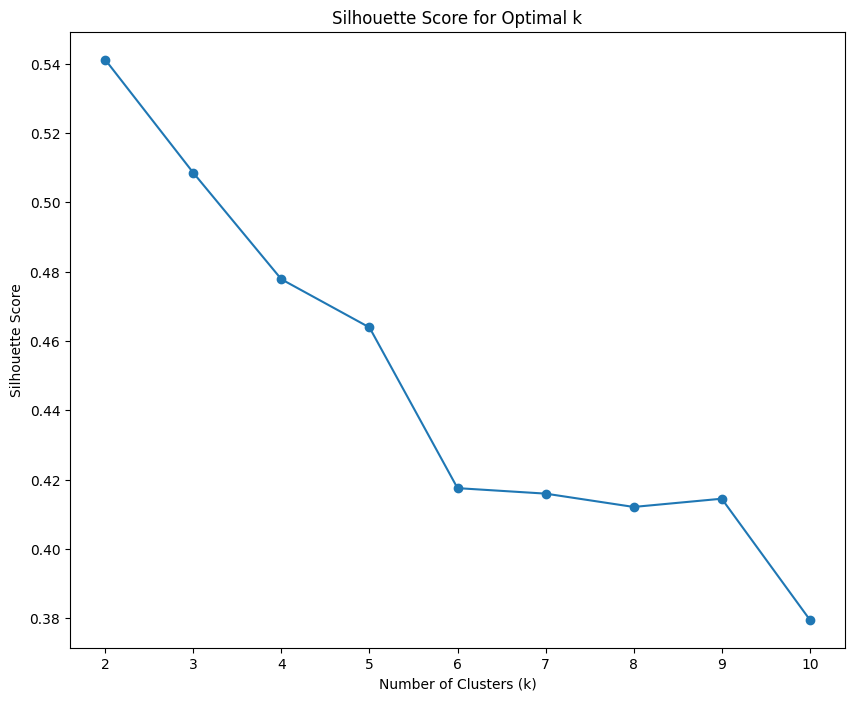

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Inisialisasi nilai k
k_values = range(2, 11)

# Inisialisasi list untuk menampung nilai silhouette score
silhouette_scores = []

# Melakukan KMeans untuk setiap nilai k dan menghitung silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_assignments = kmeans.fit_predict(rfm_df_scaled)
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_assignments)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(k, silhouette_avg))

# Menampilkan grafik silhouette score
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


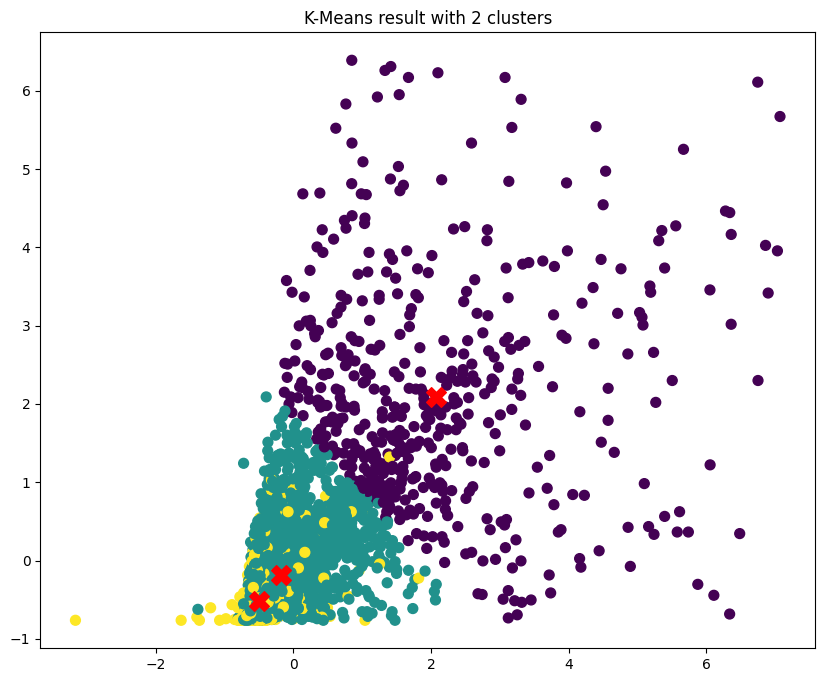

Cluster means:
     Amount  Frequency   Recency
0  2.067013   2.088677 -0.701471
1 -0.181549  -0.179211 -0.475773
2 -0.502376  -0.518466  1.542128

Clustering vector:
[2 0 1 ... 2 1 1]


In [64]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

# Get cluster assignments
cluster_assignments = kmeans.labels_

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Plotting K-Means results
plt.scatter(rfm_df_scaled.iloc[:, 0], rfm_df_scaled.iloc[:, 1], c=cluster_assignments, cmap='viridis', marker='o', s=50)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X')
plt.title('K-Means result with 2 clusters')
plt.show()

# Displaying cluster means
cluster_means = pd.DataFrame(cluster_centers, columns=rfm_df_scaled.columns)
print("Cluster means:")
print(cluster_means)

# Displaying clustering vector
print("\nClustering vector:")
print(cluster_assignments)

# # Displaying within cluster sum of squares by cluster
# within_cluster_sumsquares = kmeans.inertia_
# print("\nWithin cluster sum of squares by cluster:")
# print(within_cluster_sumsquares)

# # Displaying additional information
# print("\nAvailable components:")
# print(kmeans)


In [65]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1])

In [66]:
# assign the label
hasil = rfm
hasil['Cluster_Id'] = kmeans.labels_
hasil

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2
...,...,...,...,...,...
4366,18278.0,173.90,9,73,1
4367,18280.0,180.60,10,277,2
4368,18281.0,80.82,7,180,2
4369,18282.0,176.60,13,7,1


In [67]:
# Misalnya, jika 'StockCode' adalah kunci yang sesuai
data_merged = pd.merge(retail,hasil, on='CustomerID', how='left')
data_merged.to_csv('clustered_data.csv', index=False)
data_merged


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount_x,Diff,Amount_y,Frequency,Recency,Cluster_Id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00,5288.63,312.0,301.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,5288.63,312.0,301.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00,5288.63,312.0,301.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,5288.63,312.0,301.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,5288.63,312.0,301.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,0 days 00:00:00,862.81,52.0,0.0,1.0
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,0 days 00:00:00,862.81,52.0,0.0,1.0
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0 days 00:00:00,862.81,52.0,0.0,1.0
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0 days 00:00:00,862.81,52.0,0.0,1.0


In [71]:
# Fungsi rekomendasi produk
def recommend_products_from_existing_cluster(cluster_data, cluster_column='Cluster_Id', num_recommendations=5):
    recommendations = {}

    # Loop melalui setiap kluster
    for cluster_label in cluster_data[cluster_column].unique():
        # Filter data berdasarkan kluster
        cluster_df = cluster_data[cluster_data[cluster_column] == cluster_label]

        # Analisis produk yang sering dibeli dalam kluster
        top_products_cluster = cluster_df['Description'].value_counts().head(num_recommendations).index.tolist()

        # Mencatat rekomendasi untuk kluster
        recommendations[cluster_label] = top_products_cluster

    return recommendations

# Membaca data dari CSV (pastikan data Anda memiliki kolom 'CustomerID', 'Description', 'Cluster')
data = pd.read_csv('clustered_data.csv')

# Preprocessing deskripsi produk
data['Description'] = data['Description'].astype(str).apply(preprocessing)

# Rekomendasi Produk dari Klaster yang sudah ada
recommendations = recommend_products_from_existing_cluster(data)

# Menampilkan hasil rekomendasi
for cluster_label, recommended_products in recommendations.items():
    print(f"\nRekomendasi untuk Cluster {cluster_label}:")
    for product in recommended_products:
        print(f"- {product}")



Rekomendasi untuk Cluster 0.0:
- jumbo bag red retrospot
- white hanging heart t-light holder
- lunch bag red retrospot
- regency cakestand 3 tier
- assorted colour bird ornament

Rekomendasi untuk Cluster 1.0:
- white hanging heart t-light holder
- regency cakestand 3 tier
- assorted colour bird ornament
- postage
- party bunting

Rekomendasi untuk Cluster 2.0:
- white hanging heart t-light holder
- regency cakestand 3 tier
- party bunting
- assorted colour bird ornament
- rex cash+carry jumbo shopper

Rekomendasi untuk Cluster nan:


In [70]:
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.cluster import KMeans

# # Fungsi preprocessing
# def preprocessing(line):
#     line = line.lower()
#     return line

# # Fungsi rekomendasi produk
# def recommend_products(cluster_data, product_names, cluster_column='Cluster_Id', num_recommendations=5):
#     recommendations = {}

#     # Loop melalui setiap kluster
#     for cluster_label in cluster_data[cluster_column].unique():
#         # Filter data berdasarkan kluster
#         cluster_df = cluster_data[cluster_data[cluster_column] == cluster_label]

#         # Analisis produk yang sering dibeli dalam kluster
#         top_products_cluster = cluster_df['Description'].value_counts().head(num_recommendations).index.tolist()

#         # Mencatat rekomendasi untuk kluster
#         recommendations[cluster_label] = top_products_cluster

#     return recommendations

# # Membaca data dari CSV (pastikan data Anda memiliki kolom 'CustomerID', 'Description', 'Cluster')
# data = pd.read_csv('clustered_data.csv')

# # Preprocessing deskripsi produk
# data['Description'] = data['Description'].astype(str).apply(preprocessing)

# # TF-IDF Vectorization
# vectorizer = TfidfVectorizer(stop_words='english')
# product_matrix = vectorizer.fit_transform(data['Description'])

# # K-Means Clustering
# k = 3  # Sesuaikan dengan jumlah kluster yang Anda miliki
# kmeans = KMeans(n_clusters=k, random_state=42)
# data['Cluster_Id'] = kmeans.fit_predict(product_matrix)

# # Misalnya, jika Anda memiliki DataFrame produk dengan kolom 'StockCode' dan 'Description'
# product_names = data[['StockCode', 'Description']].set_index('StockCode')['Description'].to_dict()

# # Rekomendasi Produk
# recommendations = recommend_products(data, product_names)

# # Menampilkan hasil rekomendasi
# for cluster_label, recommended_products in recommendations.items():
#     print(f"\nRekomendasi untuk Cluster {cluster_label}:")
#     for product in recommended_products:
#         print(f"- {product}")


c:\Users\ASUS\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Rekomendasi untuk Cluster 0:
- white hanging heart t-light holder
- regency cakestand 3 tier
- assorted colour bird ornament
- party bunting
- postage

Rekomendasi untuk Cluster 2:
- set of 3 cake tins pantry design 
- pack of 72 retrospot cake cases
- jam making set with jars
- set of 4 pantry jelly moulds
- baking set 9 piece retrospot 

Rekomendasi untuk Cluster 1:
- jumbo bag red retrospot
- lunch bag red retrospot
- lunch bag  black skull.
- lunch bag spaceboy design 
- lunch bag cars blue


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Membaca data dari CSV (pastikan data Anda memiliki kolom 'CustomerID', 'Description', 'Cluster_Id')
data = pd.read_csv('clustered_data.csv')

# Misalnya, jika Anda memiliki DataFrame produk dengan kolom 'StockCode' dan 'Description'
product_names = data[['StockCode', 'Description']].set_index('StockCode')['Description'].to_dict()

# Hasil klustering yang Anda miliki
# Misalnya, hasil klustering ada di kolom 'Cluster_Id'
# Sesuaikan dengan kolom klustering yang sesuai dengan data Anda
cluster_column = 'Cluster_Id'
product_mapper = {stock_code: i for i, stock_code in enumerate(product_names.keys())}
# Membuat objek TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
product_matrix = vectorizer.fit_transform(data['Description'])

# Fungsi rekomendasi produk
def recommend_products_by_name(data, product_names, target_product_name, cluster_column, num_recommendations=5):
    target_product_id = None
    # Cari ID produk berdasarkan nama produk target
    for stock_code, description in product_names.items():
        if description.lower() == target_product_name.lower():
            target_product_id = stock_code
            break

    if target_product_id is None:
        print(f"Product with name '{target_product_name}' not found.")
        return

    # Ambil kluster dari produk target
    target_cluster = data[data['StockCode'] == target_product_id][cluster_column].values[0]

    # Filter produk dalam kluster yang sama
    cluster_products = data[data[cluster_column] == target_cluster]

    # Hapus produk target dari rekomendasi (jika ada)
    cluster_products = cluster_products[cluster_products['StockCode'] != target_product_id]
    
    # Sortir produk berdasarkan skor kecocokan dengan produk target
    cluster_products['Similarity'] = cluster_products['StockCode'].apply(
        lambda x: cosine_similarity(product_matrix[product_mapper[x]], product_matrix[product_mapper[target_product_id]])[0][0]
    )
    cluster_products = cluster_products.sort_values(by='Similarity', ascending=False).head(num_recommendations)

    # Tampilkan hasil rekomendasi
    print(f"Rekomendasi untuk produk '{target_product_name}' (Cluster_Id {target_cluster}):")
    for index, row in cluster_products.iterrows():
        recommended_product_name = product_names.get(row['StockCode'], "Unknown Product")
        print(f"- {recommended_product_name} (ID: {row['StockCode']}), Similarity: {row['Similarity']:.2f}")

# Contoh penggunaan
target_product_name = "ALARM CLOCK BAKELIKE GREEN"
recommend_products_by_name(data, product_names, target_product_name, cluster_column)


KeyboardInterrupt: 

## Analisis

Analisis dari hasil cluster means:

### Cluster 0:
- **Amount:** Rata-rata 2.067013, menunjukkan bahwa pelanggan dalam kelompok ini cenderung memiliki total jumlah pembelian yang relatif tinggi.
- **Frequency:** Rata-rata 2.088677, menunjukkan bahwa pelanggan dalam kelompok ini cenderung melakukan pembelian dengan frekuensi tinggi.
- **Recency:** Rata-rata -0.701471, mungkin mengindikasikan bahwa pelanggan dalam kelompok ini memiliki waktu sejak pembelian yang relatif baru.

### Cluster 1:
- **Amount:** Rata-rata -0.181549, menunjukkan bahwa pelanggan dalam kelompok ini cenderung memiliki total jumlah pembelian yang lebih rendah dibandingkan dengan Cluster 0.
- **Frequency:** Rata-rata -0.179211, menunjukkan bahwa pelanggan dalam kelompok ini cenderung melakukan pembelian dengan frekuensi yang lebih rendah dibandingkan dengan Cluster 0.
- **Recency:** Rata-rata -0.475773, mungkin mengindikasikan bahwa pelanggan dalam kelompok ini memiliki waktu sejak pembelian yang tidak terlalu baru.

### Cluster 2:
- **Amount:** Rata-rata -0.502376, menunjukkan bahwa pelanggan dalam kelompok ini cenderung memiliki total jumlah pembelian yang lebih rendah dibandingkan dengan Cluster 0 dan 1.
- **Frequency:** Rata-rata -0.518466, menunjukkan bahwa pelanggan dalam kelompok ini cenderung melakukan pembelian dengan frekuensi yang lebih rendah dibandingkan dengan Cluster 0 dan 1.
- **Recency:** Rata-rata 1.542128, mungkin mengindikasikan bahwa pelanggan dalam kelompok ini memiliki waktu sejak pembelian yang lebih lama.

### Kesimpulan:
- Cluster 0 dapat dianggap sebagai kelompok pelanggan yang berharga tinggi, karena mereka memiliki total pembelian yang tinggi dan sering berbelanja dengan waktu sejak pembelian yang relatif baru.
- Cluster 1 mungkin adalah kelompok pelanggan yang berinteraksi sedang dengan bisnis, dengan total pembelian dan frekuensi belanja yang sedang, serta waktu sejak pembelian yang tidak terlalu baru.
- Cluster 2 mungkin mencakup pelanggan yang berinteraksi kurang dengan bisnis, dengan total pembelian dan frekuensi belanja yang lebih rendah, serta waktu sejak pembelian yang lebih lama.